In [1]:
import re
from zipfile import ZipFile
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from langdetect import detect, DetectorFactory
from transformers import set_seed
from collections import Counter
import nltk
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('stopwords')

# Set seeds for reproducible and consistent results
set_seed(42)





/home/tom/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to /home/tom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Descriptive statistics of all data (not training data)

In [2]:
# Load original data not sampled
with ZipFile('Data/checkpoint2.zip', 'r') as zip:
        with zip.open('checkpoint2.csv') as file:
                reviews = pd.read_csv(file)

In [3]:
reviews['sentiment'] = reviews['label'].copy()
# Replace 1 with 'POS' and 0 with 'NEG'
reviews['sentiment'].replace({1: 'POS', 0: 'NEG'}, inplace=True)
print(reviews['sentiment'])

0          POS
1          POS
2          NEG
3          NEG
4          POS
          ... 
2094072    POS
2094073    POS
2094074    NEG
2094075    NEG
2094076    POS
Name: sentiment, Length: 2094077, dtype: object


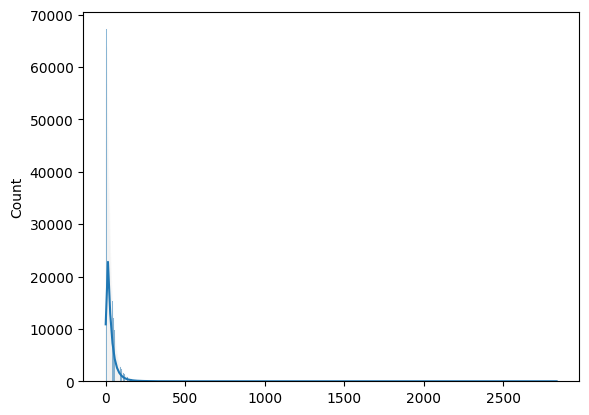

Number of reviews with more than 1024 tokens: 54
Number of reviews with more than 512 tokens: 688
Average number of tokens: 31.85128579321582


In [5]:
# Get a rough understanding of the tokens
revs = reviews['text'].copy()

doc_lengths = []

for rev in revs:
    tokens = nltk.word_tokenize(rev)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.histplot(doc_lengths, kde=True)
#plt.title("Word length of reviews")
plt.savefig('Plots/doc_len.pdf',format='pdf', dpi=1500)
plt.show()

print('Number of reviews with more than 1024 tokens:', str(np.sum(doc_lengths > 1024)))
print('Number of reviews with more than 512 tokens:', str(np.sum(doc_lengths > 512)))
print('Average number of tokens:', str(np.average(doc_lengths)))

#### Clean text and tokenize to create meaningful WordClouds

In [7]:
PUNCTUATION = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""" 


def clean_text(text):
    """Doc cleaning"""
    
    # Lowering text
    text = text.lower()
    
    # Removing punctuation
    text = "".join([c for c in text if c not in PUNCTUATION])
    
    # Removing whitespace and newlines
    text = re.sub('\s+',' ',text)
    
    return text

reviews['cleaned_text'] = reviews['text'].apply(clean_text)

In [8]:
# Split on whitespaces, remove puncutation, remove stopwords
def tokenize_and_process(df, text_column):
    stop_words = set(stopwords.words('english'))
    punctuation_table = str.maketrans('', '', string.punctuation)
    
    def process_text(text):
        # Split text by whitespace
        words = word_tokenize(text)
        # Remove punctuation and stopwords
        cleaned_words = [word.translate(punctuation_table).lower() for word in words if word.isalnum() and word.lower() not in stop_words]
        return cleaned_words
    
    df[text_column + 'SplitAndCleaned'] = df[text_column].apply(process_text)
    return df

# Get splitted cleaned tokens
reviews = tokenize_and_process(reviews, 'text')

# Check the DataFrame
display(reviews)


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label,sentiment,textLengths,cleaned_text,textSplitAndCleaned,textLength
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,3,True,2020-01-09 00:06:34.489,2020-01-09,en,1,POS,67,i think this locket is really pretty the insid...,"[think, locket, really, pretty, inside, back, ...",30
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1608426246701,0,True,2020-12-20 01:04:06.701,2020-12-20,en,1,POS,1,great,[great],1
2,2.0,Two Stars,One of the stones fell out within the first 2 ...,[],B007ZSEQ4Q,B007ZSEQ4Q,AHITBJSS7KYUBVZPX7M2WJCOIVKQ,1432344828000,3,True,2015-05-23 01:33:48.000,2015-05-23,en,0,NEG,20,one of the stones fell out within the first 2 ...,"[one, stones, fell, within, first, 2, weeks, w...",11
3,1.0,Won’t buy again,Crappy socks. Money wasted. Bought to wear wit...,[],B07F2BTFS9,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,2,True,2018-12-31 20:57:27.095,2018-12-31,en,0,NEG,21,crappy socks money wasted bought to wear with ...,"[crappy, socks, money, wasted, bought, wear, t...",10
4,5.0,I LOVE these glasses,I LOVE these glasses! They fit perfectly over...,[],B00PKRFU4O,B00XESJTDE,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,0,True,2015-08-13 14:29:26.000,2015-08-13,en,1,POS,64,i love these glasses they fit perfectly over m...,"[love, glasses, fit, perfectly, regular, recta...",27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094072,5.0,Five Stars,Great quality. Sturdy and tight. Came on time....,[],B00YGFMQC0,B00YGFMQC0,AEEMZHE5K6EIQHLIGHCNYJTWDUIA,1474207318000,0,True,2016-09-18 14:01:58.000,2016-09-18,en,1,POS,14,great quality sturdy and tight came on time gr...,"[great, quality, sturdy, tight, came, time, gr...",8
2094073,5.0,... allowed them to be used to add military ri...,The tie tacks were the size that allowed them ...,[],B00YGFMQC0,B00YGFMQC0,AFXSFD3FTZ2CLN3TYV4B63CQM5BQ,1466799158000,0,True,2016-06-24 20:12:38.000,2016-06-24,en,1,POS,31,the tie tacks were the size that allowed them ...,"[tie, tacks, size, allowed, used, add, militar...",16
2094074,1.0,Didn’t come with all ten,Says ten tie clips but o only received 7.,[],B00YGFMQC0,B00YGFMQC0,AEH7WP5HGM6FGLSSC6GSTYUXBHGQ,1525799105585,0,True,2018-05-08 17:05:05.585,2018-05-08,en,0,NEG,10,says ten tie clips but o only received 7,"[says, ten, tie, clips, received, 7]",6
2094075,3.0,Not checked for quality,When I received them 2-3 of them did not open ...,[],B00YGFMQC0,B00YGFMQC0,AEL2TSSBVLIPWQ7YVMK364DUYURQ,1482013711000,0,True,2016-12-17 22:28:31.000,2016-12-17,en,0,NEG,19,when i received them 23 of them did not open p...,"[received, open, properly, looks, though, brea...",7


Number of reviews with more than 1024 tokens: 0
Number of reviews with more than 512 tokens: 18
Number of reviews with more than 150 tokens: 1898
Average number of tokens: 13.44116095062407


#### Rating distribution

In [6]:
ratings = pd.DataFrame(reviews['rating'].value_counts())
ratings

,count
rating,
5.0,1176938
4.0,294356
1.0,259760
3.0,211405
2.0,151618


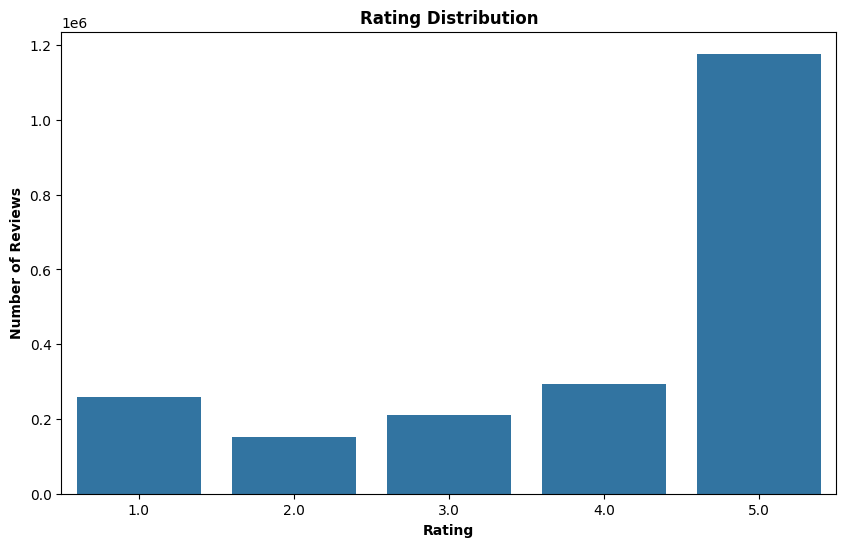

In [9]:
plt.figure(figsize=(10, 6))
# Plot bar graph using seaborn
sns.barplot(x='rating', y='count', data=ratings)
# Set plot title and labels
plt.title('Rating Distribution', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')

#Save the plot
plt.savefig('Plots/rating_distribution_all.pdf',format='pdf', dpi=1500)

# Show the plot
plt.show()

#### Sentiment distribution

In [10]:
# Group by Review_Score and Sentiment
sentiment_distribution = reviews.groupby(['rating','sentiment']).size().reset_index(name='Count')
sentiment_distribution 

,rating,sentiment,Count
0,1.0,NEG,249857
1,1.0,POS,9903
2,2.0,NEG,135674
3,2.0,POS,15944
4,3.0,NEG,132765
5,3.0,POS,78640
6,4.0,NEG,42416
7,4.0,POS,251940
8,5.0,NEG,23329
9,5.0,POS,1153609


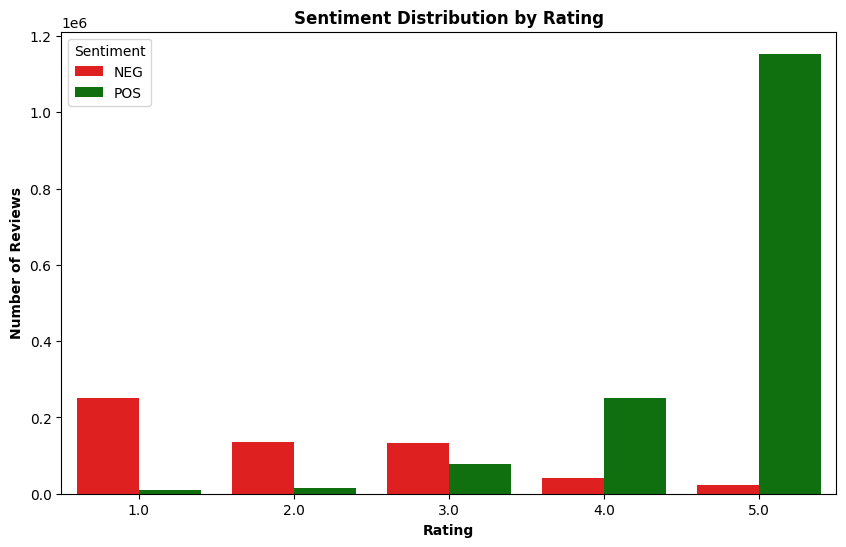

In [11]:
# Sentiment distributions

plt.figure(figsize=(10, 6))
# Plot bar graph using seaborn
sns.barplot(x='rating', y='Count', hue='sentiment', data=sentiment_distribution, palette=['red', 'green'])
# Set plot title and labels
plt.title('Sentiment Distribution by Rating', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')
plt.legend(title='Sentiment')

# Save the plot
plt.savefig('Plots/sentiment_dist_by_rating.pdf',format='pdf', dpi=1500)

# Show the plot
plt.show()

#### WordClouds

In [13]:
# Combine the words into a single string
text = ' '.join([' '.join(review) for review in reviews['textSplitAndCleaned']])

# Wordcloud of common words
wordcloud = WordCloud(width=4000, height=2000, background_color ='black').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('Plots/wordcloud.pdf', format='pdf', dpi=1500)
plt.show()

In [ ]:
# Define a function to generate word cloud for a given rating
def generate_wordcloud_for_rating(df, rating):
    # Filter the DataFrame for the given rating
    filtered_df = df[df['Score'] == rating]
    # Combine the text from the 'Cleaned_Text' column into a single string
    text = ' '.join([' '.join(review) for review in filtered_df['textSplitAndCleaned']])
    # Generate the word cloud
    wordcloud = WordCloud(width=4000, height=2000, background_color='black').generate(text)
    return wordcloud

# Create a figure with subplots for each rating
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Generate and plot word clouds for each rating
for rating in range(1, 6):
    wordcloud = generate_wordcloud_for_rating(reviews, rating)
    ax = axes[(rating-1) // 2, (rating-1) % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Rating {rating}', fontsize=16, weight='bold')
    ax.axis('off')

# Adjust layout and remove the empty subplot
plt.delaxes(axes[2][1])  # remove the empty subplot if there is any
plt.savefig('Plots/wordclouds_by_rating.pdf', format='pdf', dpi=1500)
plt.show()

## Descriptive statistics of training data

In [10]:
# Load sampled training data
with ZipFile('Data/checkpoint3.zip', 'r') as zip:
        with zip.open('checkpoint3.csv') as file:
                reviews = pd.read_csv(file)

In [11]:
ratings = pd.DataFrame(reviews['rating'].value_counts())
ratings

,count
rating,
5.0,33010
1.0,25751
3.0,15933
2.0,14191
4.0,11115


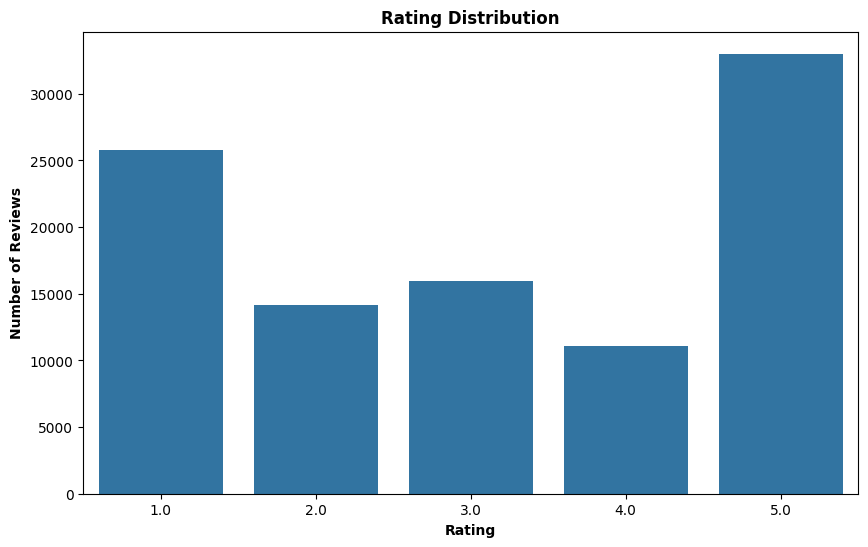

In [12]:
plt.figure(figsize=(10, 6))
# Plot bar graph using seaborn
sns.barplot(x='rating', y='count', data=ratings)
# Set plot title and labels
plt.title('Rating Distribution', weight='bold')
plt.xlabel('Rating', weight='bold')
plt.ylabel('Number of Reviews', weight='bold')

#Save the plot
plt.savefig('Plots/rating_distribution_train.pdf',format='pdf', dpi=1500)

# Show the plot
plt.show()

#### BERTopic results
--> from topic_modelling.ipynb run on kaggle

In [13]:
with ZipFile('Data/topic_models.zip', 'r') as zip:
        
        # Topic modelling with review content
        with zip.open('text_topics.csv') as file:
                text_topics = pd.read_csv(file) 
                file.close()
        
        # Topic modelling with titles of reviews 
        with zip.open('title_topics.csv') as file:
                title_topics = pd.read_csv(file)
                file.close()


# Also for product names interesting?

In [14]:
display(text_topics)

,Topic,Count,Name,Representation,Representative_Docs
0,0,51963,0_size_fit_small_dress,"['size', 'fit', 'small', 'dress', 'like', 'wea...","[""SPAAAAAACE PAAAAANTTTSSS!<br /><br />I can n..."
1,1,12857,1_earrings_necklace_ring_like,"['earrings', 'necklace', 'ring', 'like', 'colo...","['I received this ring today, the shipping was..."
2,2,15737,2_quality_cheap_great_good,"['quality', 'cheap', 'great', 'good', 'love', ...","[""Cheap , flimsy, broke in the first week,scre..."
3,3,4756,3_watch_band_wrist_strap,"['watch', 'band', 'wrist', 'strap', 'br', 'tim...","[""The Beauty7 Heavy Black 18-24mm Stainless St..."
4,4,4921,4_glasses_mask_sunglasses_lenses,"['glasses', 'mask', 'sunglasses', 'lenses', 'f...","[""Lost a valve on my previous mask, and this o..."
5,5,3659,5_bag_purse_wallet_zipper,"['bag', 'purse', 'wallet', 'zipper', 'pockets'...","[""It's a good wallet to carry a few cards and ..."
6,6,1525,6_expected_exactly_ok_nothing,"['expected', 'exactly', 'ok', 'nothing', 'desc...","['Exactly as I expected!', 'exactly as expecte..."
7,7,2108,7_shipping_fast_arrived_received,"['shipping', 'fast', 'arrived', 'received', 'p...","['Great product and fast shipping', 'Fast ship..."
8,8,814,8_pin_pins_one_plugs,"['pin', 'pins', 'one', 'plugs', 'br', 'get', '...","['Made well and looks very pretty, but it is h..."
9,9,611,9_lights_battery_light_work,"['lights', 'battery', 'light', 'work', 'batter...","[""It's pretty much useless since the brand new..."


In [15]:
display(title_topics)

,Topic,Count,Name,Representation,Representative_Docs
0,0,34307,0_small_fit_size_dress,"['small', 'fit', 'size', 'dress', 'great', 'co...",['Material was a really loose fit and way to b...
1,1,21747,1_cute_love_disappointed_beautiful,"['cute', 'love', 'disappointed', 'beautiful', ...","['Super cute and good quality', 'This is a rea..."
2,2,14308,2_stars_five_star_one,"['stars', 'five', 'star', 'one', 'three', 'fou...","['Five Stars', 'Five Stars', 'Five Stars']"
3,3,15655,3_quality_buy_cheap_product,"['quality', 'buy', 'cheap', 'product', 'money'...","[""Cheap quality. Don't recommend."", 'Poor qual..."
4,4,5994,4_watch_broke_band_broken,"['watch', 'broke', 'band', 'broken', 'belt', '...","['Strap broke within two weeks.', 'Zipper brok..."
5,5,3907,5_color_colors_smell_red,"['color', 'colors', 'smell', 'red', 'green', '...",['... vibrant bright yellow shown n picture in...
6,6,1416,6_sun_summer_waterproof_breathable,"['sun', 'summer', 'waterproof', 'breathable', ...","['Great sun protection', 'Great sun protection..."
7,7,884,7_see_hole_holes_blurry,"['see', 'hole', 'holes', 'blurry', 'unflatteri...","['See through', 'See through!', 'See through!']"
8,8,875,8_pass_go_beware_avoid,"['pass', 'go', 'beware', 'avoid', 'protection'...","['Pass', 'Pass.', 'Pass']"
9,9,361,9_wanted_exactly_looking_needed,"['wanted', 'exactly', 'looking', 'needed', 'th...","['Exactly what she wanted.', 'Not Exactly What..."
